In [107]:
import time
#import regex as re

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pickle
#import json

#import zhconv
#import xpinyin

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 40)
pd.set_option('display.min_rows', 40)
pd.set_option('display.max_columns', None)
import openpyxl

import torch
import torch.nn as nn
import torchvision
import sklearn

import scipy

import skimage
import PIL

#import sklearn
# from sklearn.model_selection import train_test_split
# import sklearn.preprocessing as preprocessing

from tqdm import tqdm

#import wand
#from wand.drawing import Drawing
#from wand.image import Image

import copy

import threading

import wandb

from sklearn.metrics import average_precision_score

In [108]:
# 此部分要用到的常量
print("torch.cuda.is_available():", torch.cuda.is_available())
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("DEVICE", DEVICE)

torch.cuda.is_available(): True
DEVICE cuda:0


# [A] 图像读入与预处理

### [A1] 获得 Dataset

In [109]:
def x_to_pq(x, W_b):
    p = int(round(x // W_b))
    q = x % W_b / (W_b / 2) - 1
    return p, q

def pq_to_x(p, q, W_b):
    return p * W_b + (q + 1) / 2 * W_b

def clamp_x(x, png_w):
    if x < 0:
        return 0
    elif x >= png_w:
        return png_w - 1
    else:
        return x

In [110]:
class Dataset_XN(torch.utils.data.Dataset):
    
    def __init__(self, ROOT, only_first_items=0, DESIRED_H=128, DESIRED_W=1280, only_first_x_csvs=0):
        
        self.ROOT = ROOT
        self.DESIRED_H = DESIRED_H
        self.DESIRED_W = DESIRED_W
        
        self.B = 80
        self.F_main = 4
        self.W_b = self.DESIRED_W / self.B
        
        # read self.DATA_DF
        self.DATA_DF = pd.read_csv(os.path.join(ROOT, 'csv.csv'))
        if only_first_x_csvs > 0:
            self.DATA_DF = self.DATA_DF.iloc[:only_first_x_csvs+1]
        
        # group self.DATA_DF by png_file
        self.DATA_GROUPED = self.DATA_DF.groupby('png_file')
        self.DATA_KEYS = list(self.DATA_GROUPED.groups.keys())
        
        # pre-processing
        self.preproc = {
            'q_mu': 0,
            'q_sigma': 1,
            'l_mu': 0,
            'l_sigma': 1,
            'r_mu': 0,
            'r_sigma': 1,
        }
        
    def __getitem__(self, index):

        key = self.DATA_KEYS[index]
        rows = self.DATA_GROUPED.get_group(key)
        
        # load image from disk
        png_path = os.path.join(self.ROOT, 'png', key + '.png')
        img = np.array(PIL.Image.open(png_path)).astype(np.float32) / 255
        assert img.shape == (self.DESIRED_H, self.DESIRED_W)

        # make tensor
        x = torch.from_numpy(img)
        
        exception_num = 0
        set_indicator = np.zeros(shape=(self.B,), dtype=bool)
        to_y_main = np.zeros(shape=(self.B, self.F_main), dtype=np.float32)
        to_y_type = np.zeros(shape=(self.B), dtype=np.int64)
        to_y_dot_t = np.zeros(shape=(self.B), dtype=np.int64)
        to_y_dot_b = np.zeros(shape=(self.B), dtype=np.int64)
        to_y_dot_r = np.zeros(shape=(self.B), dtype=np.int64)
        to_y_uline = np.zeros(shape=(self.B), dtype=np.int64)
        for index, row in rows.iterrows():
            x_c = clamp_x(row['x'], self.DESIRED_W)
            x_min = clamp_x(row['x_min'], self.DESIRED_W)
            x_max = clamp_x(row['x_max'], self.DESIRED_W)
            p, q = x_to_pq(x_c, self.W_b)
            if set_indicator[p]:
                exception_num += 1
            else:
                set_indicator[p] = True
                l = x_c - x_min
                r = x_max - x_c
                c = 1
                to_y_main[p, 0] = (q - self.preproc['q_mu']) / self.preproc['q_sigma']
                to_y_main[p, 1] = (l - self.preproc['l_mu']) / self.preproc['l_sigma']
                to_y_main[p, 2] = (r - self.preproc['r_mu']) / self.preproc['r_sigma']
                to_y_main[p, 3] = c
                to_y_type[p] = row['type']
                to_y_dot_t[p] = row['dot_t']
                to_y_dot_b[p] = row['dot_b']
                to_y_dot_r[p] = row['dot_r']
                to_y_uline[p] = row['uline']

        # to_y[~set_indicator, 3] = -self.preproc['c_mu']
        y_main = torch.from_numpy(to_y_main)
        y_type = torch.from_numpy(to_y_type)
        y_dot_t = torch.from_numpy(to_y_dot_t)
        y_dot_b = torch.from_numpy(to_y_dot_b)
        y_dot_r = torch.from_numpy(to_y_dot_r)
        y_uline = torch.from_numpy(to_y_uline)
        return x, y_main, y_type, y_dot_t, y_dot_b, y_dot_r, y_uline, exception_num
        
    def __len__(self):
        return len(self.DATA_KEYS)
    
    # def view_split_by_ratio(self, splits=[0.8,], seed=777):
    #     main_view = np.arange(len(self.FILENAMES))
    #     rng = np.random.default_rng(seed)
    #     rng.shuffle(main_view)
    #     assert len(splits) >= 1
    #     split_begin = 0
    #     result = []
    #     for split in splits:
    #         split_end = int(split * len(main_view))
    #         result.append(main_view[split_begin:split_end])
    #         split_begin = split_end
    #     result.append(main_view[split_end:])
    #     return [RowDatasetView(self, view) for view in result]

In [111]:
def pack_y(y_main, y_type, y_dot_t, y_dot_b, y_dot_r, y_uline):
    return {
        'q': y_main[..., 0],
        'l': y_main[..., 1],
        'r': y_main[..., 2],
        'c': y_main[..., 3],
        'type': y_type,
        'dot_t': y_dot_t,
        'dot_b': y_dot_b,
        'dot_r': y_dot_r,
        'uline': y_uline,
    }

In [112]:
def inv_preproc(y, preproc):
    yy = { key: y[key] for key in y if key not in ['q', 'l', 'r'] }
    yy['q'] = y['q'] * preproc['q_sigma'] + preproc['q_mu']
    yy['l'] = y['l'] * preproc['l_sigma'] + preproc['l_mu']
    yy['r'] = y['r'] * preproc['r_sigma'] + preproc['r_mu']
    return yy

In [113]:
# class RowDatasetView(torch.utils.data.Dataset):
    
#     def __init__(self, database, view, type='theta_y'):
#         self.database = database
#         self.view = view
#         self.type = type
        
#     def __len__(self):
#         return len(self.view)
    
#     def __getitem__(self, index):
#         return self.database.getitem(self.view[index], self.type)

下面会显示 csv 的个数

In [114]:
# PNG_SMALL_FOLDER = "..\\gen\\png_small"
# PNG_LARGE_FOLDER = "..\\gen\\png_large"
# CSV_FOLDER = "..\\gen\\csv"
# JSON_FOLDER = "..\\gen\\json"
# len(os.listdir(CSV_FOLDER))

下面会显示图像的个数

In [115]:
ACTIVE_NAME = '..\\gen_240824a\\div_240412_230605_585410'
assert os.path.exists(ACTIVE_NAME)

dataset_test = Dataset_XN(os.path.join(ACTIVE_NAME, 'xs_note_test'), only_first_x_csvs=0)
dataset_train = Dataset_XN(os.path.join(ACTIVE_NAME, 'xs_note_train'), only_first_x_csvs=0)
len(dataset_test)
len(dataset_train)

KeyboardInterrupt: 

In [ ]:
len(dataset_test)

7760

In [ ]:
dataset_test.__getitem__(2)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.7118, 10.1698, 10.1698,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.4474, 10.0205, 10.0205,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.1878,  9.7848,  9.7848,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.0326, 10.3052, 10.3052,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.8945,  9.9054,  9.9054,  1.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.00

In [ ]:
Y_TBRU_LABELS = ['0', '1', '2', '3+']
Y_TYPE_LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '-']

In [ ]:
def get_info(dataset_train, dataset_test):
    
    lst_q = []
    lst_l = []
    lst_r = []
    lst_c = []

    lst_type = []
    lst_dot_t = []
    lst_dot_b = []
    lst_dot_r = []
    lst_uline = []
    
    e_num = 0
    all_num = 0
    for i in tqdm(list(range(len(dataset_train))), ascii=True):
        x, y_main, y_type, y_t, y_b, y_r, y_u, e = dataset_train[i]
        y = pack_y(y_main, y_type, y_t, y_b, y_r, y_u)
        ct = (y['c'] >= 0.5)
        all_num += torch.sum(ct).item()
        e_num += e
        lst_q.extend(y['q'][ct].tolist())
        lst_l.extend(y['l'][ct].tolist())
        lst_r.extend(y['r'][ct].tolist())
        lst_c.extend(y['c'].tolist())
        lst_type.extend(y['type'][ct].tolist())
        lst_dot_t.extend(y['dot_t'][ct].tolist())
        lst_dot_b.extend(y['dot_b'][ct].tolist())
        lst_dot_r.extend(y['dot_r'][ct].tolist())
        lst_uline.extend(y['uline'][ct].tolist())
        
    qs = np.array(lst_q)
    ls = np.array(lst_l)
    rs = np.array(lst_r)
    cs = np.array(lst_c)
    preproc = {
            'q_mu': np.mean(qs) if len(lst_q) > 0 else 0,
            'q_sigma': np.std(qs) if len(lst_q) > 0 else 1,
            'l_mu': np.mean(ls) if len(lst_l) > 0 else 0,
            'l_sigma': np.std(ls) if len(lst_l) > 0 else 1,
            'r_mu': np.mean(rs) if len(lst_r) > 0 else 0,
            'r_sigma': np.std(rs) if len(lst_r) > 0 else 1,
    }
        
    for i in tqdm(list(range(len(dataset_test))), ascii=True):
        x, y_main, y_type, y_t, y_b, y_r, y_u, e = dataset_test[i]
        y = pack_y(y_main, y_type, y_t, y_b, y_r, y_u)
        ct = (y['c'] >= 0.5)
        all_num += torch.sum(ct).item()
        e_num += e
        lst_q.extend(y['q'][ct].tolist())
        lst_l.extend(y['l'][ct].tolist())
        lst_r.extend(y['r'][ct].tolist())
        lst_c.extend(y['c'].tolist())
        lst_type.extend(y['type'][ct].tolist())
        lst_dot_t.extend(y['dot_t'][ct].tolist())
        lst_dot_b.extend(y['dot_b'][ct].tolist())
        lst_dot_r.extend(y['dot_r'][ct].tolist())
        lst_uline.extend(y['uline'][ct].tolist())
        
    fig, (ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=9, figsize=(6, 12))
    ax0.hist(lst_q, bins=30)
    ax0.set_title("Histogram of q")
    ax1.hist(lst_l, bins=30)
    ax1.set_title("Histogram of l")
    ax2.hist(lst_r, bins=30)
    ax2.set_title("Histogram of r")
    ax3.hist(lst_c, bins=30)
    ax3.set_title("Histogram of c")
    fs_type = pd.Series(lst_type).value_counts().sort_index()
    fs_type = pd.Series(fs_type.values, index=[Y_TYPE_LABELS[i] for i in fs_type.index])
    fs_type.plot(kind='barh', ax=ax4)
    ax4.set_title('Frequencies of y_type')
    fs_dot_t = pd.Series(lst_dot_t).value_counts().sort_index()
    fs_dot_t = pd.Series(fs_dot_t.values, index=[Y_TBRU_LABELS[i] for i in fs_dot_t.index])
    fs_dot_t.plot(kind='barh', ax=ax5)
    ax5.set_title('Frequencies of y_dot_t')
    fs_dot_b = pd.Series(lst_dot_b).value_counts().sort_index()
    fs_dot_b = pd.Series(fs_dot_b.values, index=[Y_TBRU_LABELS[i] for i in fs_dot_b.index])
    fs_dot_b.plot(kind='barh', ax=ax6)
    ax6.set_title('Frequencies of y_dot_b')
    fs_dot_r = pd.Series(lst_dot_r).value_counts().sort_index()
    fs_dot_r = pd.Series(fs_dot_r.values, index=[Y_TBRU_LABELS[i] for i in fs_dot_r.index])
    fs_dot_r.plot(kind='barh', ax=ax7)
    ax7.set_title('Frequencies of y_dot_r')
    fs_uline = pd.Series(lst_uline).value_counts().sort_index()
    fs_uline = pd.Series(fs_uline.values, index=[Y_TBRU_LABELS[i] for i in fs_uline.index])
    fs_uline.plot(kind='barh', ax=ax8)
    ax8.set_title('Frequencies of y_uline')
    fig.tight_layout()

    
    return all_num, e_num, preproc

100%|##########| 7760/7760 [00:21<00:00, 359.04it/s]


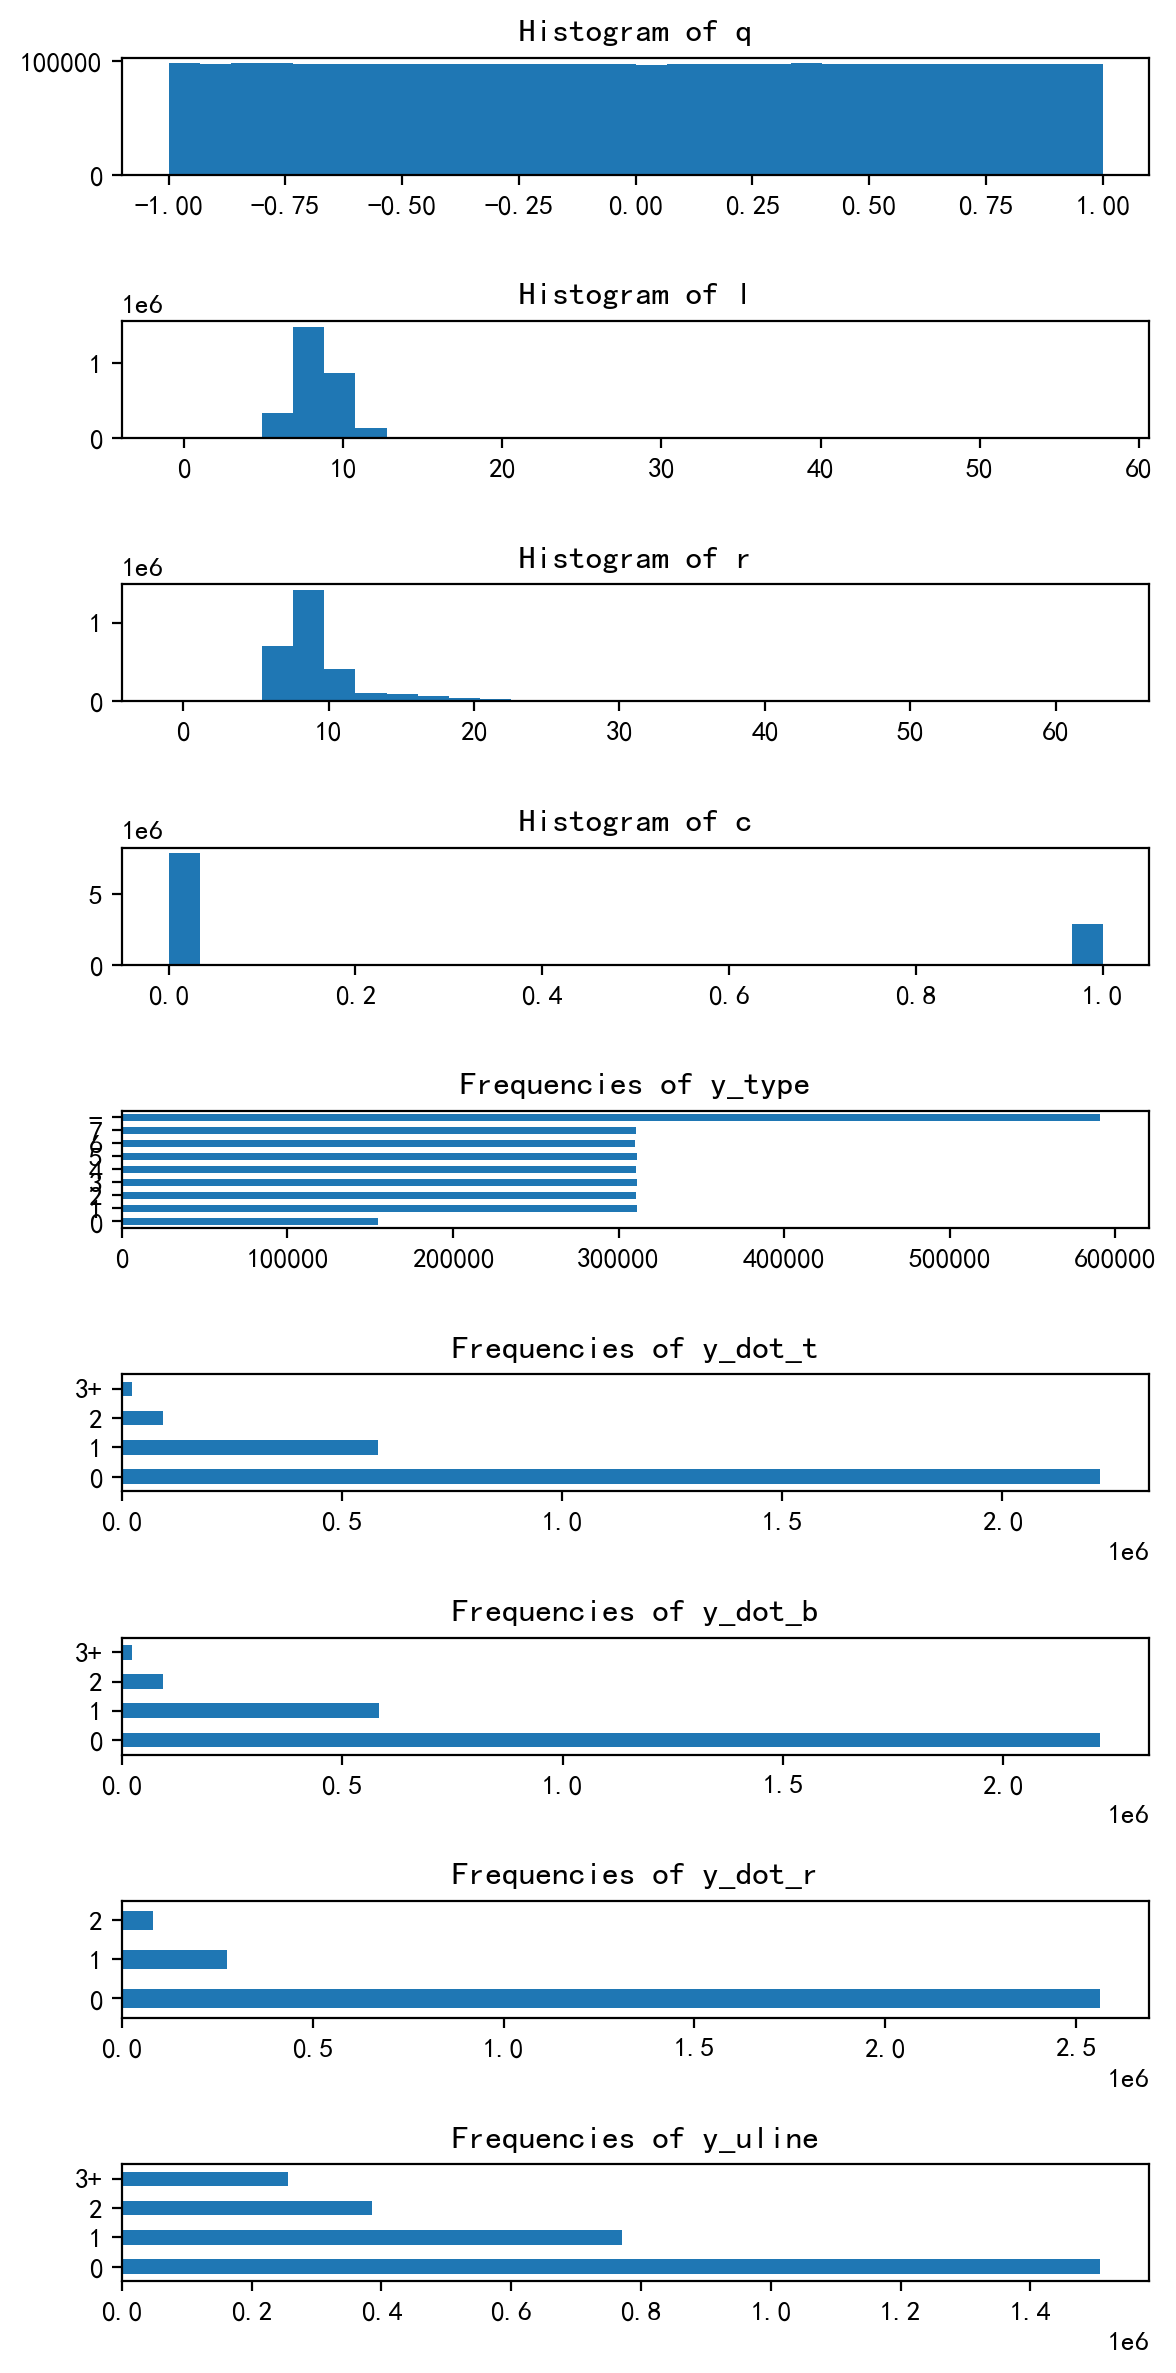

In [ ]:
all_num, e_num, preproc = get_info(dataset_train, dataset_test)

In [ ]:
preproc

{'q_mu': -0.0004339457011094265,
 'q_sigma': 0.5775287144648504,
 'l_mu': 8.6705738639644,
 'l_sigma': 2.2989245040029274,
 'r_mu': 9.452161947954844,
 'r_sigma': 3.316341778114214}

In [ ]:
dataset_test.preproc = preproc
dataset_train.preproc = preproc

In [ ]:
# all_num, e_num, preproc = get_info(dataset_train, dataset_test)

### [A2] 获得 DataLoader

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=96, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=96, shuffle=True, num_workers=0)

有需要的话再执行下面这格，耗时比较大（10 batch/s）

In [ ]:
# #先设定fig和axes
# #fig表示所有子图，axes表示一个个子图
# fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# #因为没法直接可视化具体的dataloader，所以这里我们做一个循环用于分别收集theta_truth和y_truth的值
# theta_values = []
# y_values = []

# for x, theta_truth, y_truth in tqdm(train_loader, ascii=True):
#     theta_values.extend(theta_truth.tolist())
#     y_values.extend(y_truth.tolist())
    
# for x, theta_truth, y_truth in tqdm(test_loader, ascii=True):
#     theta_values.extend(theta_truth.tolist())
#     y_values.extend(y_truth.tolist())

# #用这些值画直方图
# axes[0].hist(theta_values, bins=30)
# axes[0].set_title("Histogram of theta_truth")

# axes[1].hist(y_values, bins=30)
# axes[1].set_title("Histogram of y_truth")

# plt.tight_layout()
# plt.show()

# [B] 定义网络

In [ ]:
WANDB = False

In [ ]:
#（可选）初始化 wandb
wandb.init(
    # set the wandb project where this run will be logged
    project="GP_240328_XsNotes",
    
    # track hyperparameters and run metadata
    config={
        "architecture": "CNN_BASELINE",
        "dataset": "xsnotes",
        "epochs": 10,
    }
)

WANDB = True

ap30,▁▂▄▆▆▆▆▆▆▆▆▅██▅▇▇▆▆▇
ap50,▁▂▄▆▆▆▆▆▇▆▆▆██▆▇▇▆▆█
ap70,▁▂▅▇▇▇▇▇▇▇▇▇██▇██▇▇█
c_acc,▁▄▇▇▆▆▆▆██▇▇████▇███
c_dist,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
c_p,▁▃██▆▆▆▆█▇▇▇█▇██▇█▇▇
c_r,██▁▃████▅▇▇█▆▇▅▅▇▇▇▇
ccc_dot_b_acc,▁▆▇▇▇█▇▇████████████
ccc_dot_r_acc,▁▂▃▄▄▄▄▄▅▇▇█▇███████
ccc_dot_t_acc,▁▃▅▅▆▆▆▆▆▇▆▆▇███████
ccc_l_2_acc,▁▃▆▇▇█▇▇████████▇███


## [B1] 定义网络

In [ ]:
# def sort_table_in_batch(tensor):
#     first_col_data = tensor[:, :, 0]
#     sorted_indices = torch.argsort(first_col_data, dim=1)
#     result = torch.empty_like(tensor)
#     for i, indices in enumerate(sorted_indices):
#         result[i] = tensor[i][indices]
#     return result
# def sort_table_in_batch(tensor):
#     argsort = torch.argsort(tensor[:, :, 0])
#     result = tensor.gather(1, argsort.view(tensor.size(0), -1, 1).expand(-1, -1, tensor.size(2)))
#     return result
# while True:
#     tensor = torch.rand(5, 5, 5)
#     output1 = sort_table_in_batch_1(tensor)
#     output2 = sort_table_in_batch_2(tensor)
#     assert (output1 == output2).all()
#     print('*', end='')

In [ ]:
class Conv2D(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1, bias=False, activation='tanh', dropout=0, bn=True, t=False):
        super(Conv2D, self).__init__()
        if t:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=bias)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=bias)
        if bn:
            self.bn = nn.BatchNorm2d(out_channels, eps=1e-5, momentum=0.1)
        else:
            self.bn = None
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation is None:
            self.activation = None
        else:
            raise ValueError("Invalid param 'activation' provided: {}".format(activation))
        if dropout > 0:
            self.dropout = nn.Dropout2d(dropout)
        else:
            self.dropout = None
        
    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.activation is not None:
            x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        return x

In [ ]:
class Linear(nn.Module):
    
    def __init__(self, in_features, out_features, bias=True, activation='tanh', dropout=0, bn=True):
        super(Linear, self).__init__()
        self.fc = nn.Linear(in_features, out_features, bias=bias)
        if bn:
            self.bn = nn.BatchNorm1d(out_features, eps=1e-5, momentum=0.1)
        else:
            self.bn = None
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation is None:
            self.activation = None
        else:
            raise ValueError("Invalid param 'activation' provided: {}".format(activation))
        if dropout > 0:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = None
    
    def forward(self, x):
        x = self.fc(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.activation is not None:
            x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        return x

In [ ]:
class NoteCNN(nn.Module): 
    def __init__(self):
        super(NoteCNN, self).__init__() # in: (1x) 128 x 1280
        
        # p1280: 1 x 128 x 1280
        self.p1280_convs = nn.Sequential(
            Conv2D(1, 4, (7, 5), padding=(3, 2)), # 4 x 128 x 1280
        )
        self.p1280_step = nn.MaxPool2d((4, 2), stride=(4, 2)) # 4 x 32 x 640
        self.p1280_skip = nn.Sequential(
            Conv2D(4, 2, 1), # 2 x 32 x 640
            nn.MaxPool2d((128, 16), stride=(128, 16)), # 2 x 1 x 80
        )
        
        # p640: 4 x 32 x 640
        self.p640_convs = nn.Sequential(
            Conv2D(4, 8, 5, padding=2, dropout=0.005), # 8 x 32 x 640
        )
        self.p640_step = nn.MaxPool2d(2, stride=2) # 8 x 16 x 320
        self.p640_skip = nn.Sequential(
            Conv2D(8, 4, 1), # 4 x 16 x 320
            nn.MaxPool2d((32, 8), stride=(32, 8)), # 4 x 1 x 80
        )
        
        # p320: 8 x 12 x 320
        self.p320_convs = nn.Sequential(
            Conv2D(8, 14, 5, padding=2, dropout=0.01), # 14 x 16 x 320
        )
        self.p320_step = nn.MaxPool2d(2, stride=2) # 14 x 8 x 160
        self.p320_skip = nn.Sequential(
            Conv2D(14, 6, 1), # 3 x 8 x 160
            nn.MaxPool2d((16, 4), stride=(16, 4)), # 4 x 1 x 80
        )
            
        # p160: 12 x 8 x 160
        self.p160_convs = nn.Sequential(
            Conv2D(14, 24, 5, padding=2, dropout=0.015), # 18 x 8 x 160
        )
        self.p160_step = nn.MaxPool2d(2, stride=2) # 18 x 4 x 80
        
        # p80: 18 x 4 x 80
        self.to_20 = nn.Sequential(
            Conv2D(24, 64, (2, 4), stride=(1, 4), dropout=0.01), # 50 x 3 x 20
        )
        self.skip_20 = nn.Sequential(
            Conv2D(64, 8, 1), # 50 x 3 x 20
        )
        self.to_5 = nn.Sequential(
            Conv2D(64, 128, (2, 4), stride=(1, 4), dropout=0.01), # 128 x 2 x 5
        )
        self.skip_5 = nn.Sequential(
            Conv2D(128, 24, 1), # 50 x 3 x 20
        )
        self.to_1 = nn.Sequential(
            Conv2D(128, 400, (2, 5), stride=(1, 5), dropout=0.01), # 400 x 1 x 1
        )
        self.from_1 = nn.Sequential(
            Conv2D(400, 64, (2, 5), stride=(1, 5), dropout=0.01, t=True), # 64 x 2 x 5
        )
        self.from_5 = nn.Sequential(
            Conv2D(64+24, 16, (2, 4), stride=(1, 4), dropout=0.01, t=True), # 16 x 3 x 20
        )
        self.from_20 = nn.Sequential(
            Conv2D(16+8, 6, (2, 4), stride=(1, 4), dropout=0.01, t=True), # 6 x 4 x 80
        )
        
        # p80: (18+4) x 4 x 80
        self.squeeze = nn.Sequential(
            Conv2D(24+6, 68, (4, 1), stride=(4, 1)), # 24 x 1 x 80
        )
        
        # p80: 50 x 1 x 80 (50 = 44 + 1 + 2 + 3)
        self.fc_q = nn.Sequential( # 400 -> 1
            Linear(80, 40, dropout=0.012, bn=False),
            Linear(40, 20, dropout=0.006, bn=False),
            Linear(20, 10, bn=False),
            Linear(10, 5, bn=False),
            Linear(5, 1, bn=False, activation=None),
        )
        self.fc_l = nn.Sequential( # 400 -> 1
            Linear(80, 40, dropout=0.012, bn=False),
            Linear(40, 20, dropout=0.006, bn=False),
            Linear(20, 10, bn=False),
            Linear(10, 5, bn=False),
            Linear(5, 1, bn=False, activation=None),
        )
        self.fc_r = nn.Sequential( # 400 -> 1
            Linear(80, 40, dropout=0.012, bn=False),
            Linear(40, 20, dropout=0.006, bn=False),
            Linear(20, 10, bn=False),
            Linear(10, 5, bn=False),
            Linear(5, 1, bn=False, activation=None),
        )
        self.fc_c = nn.Sequential( # 400 -> 1
            Linear(80, 40, dropout=0.012, bn=False),
            Linear(40, 20, dropout=0.006, bn=False),
            Linear(20, 10, bn=False),
            Linear(10, 5, bn=False),
            Linear(5, 1, bn=False, activation='sigmoid'),
        )
        self.fc_type = nn.Sequential( # 400 -> 9
            Linear(80, 55, dropout=0.012, bn=False),
            Linear(55, 38, dropout=0.006, bn=False),
            Linear(38, 24, bn=False),
            Linear(24, 16, bn=False),
            Linear(16, 9, bn=False),
        )
        self.fc_dot_t = nn.Sequential( # 400 -> 4
            Linear(80, 50, dropout=0.012, bn=False),
            Linear(50, 28, dropout=0.006, bn=False),
            Linear(28, 16, bn=False),
            Linear(16, 8, bn=False),
            Linear(8, 4, bn=False),
        )
        self.fc_dot_b = nn.Sequential( # 400 -> 4
            Linear(80, 50, dropout=0.012, bn=False),
            Linear(50, 28, dropout=0.006, bn=False),
            Linear(28, 16, bn=False),
            Linear(16, 8, bn=False),
            Linear(8, 4, bn=False),
        )
        self.fc_dot_r = nn.Sequential( # 400 -> 4
            Linear(80, 50, dropout=0.012, bn=False),
            Linear(50, 28, dropout=0.006, bn=False),
            Linear(28, 16, bn=False),
            Linear(16, 8, bn=False),
            Linear(8, 4, bn=False),
        )
        self.fc_uline = nn.Sequential( # 400 -> 4
            Linear(80, 50, dropout=0.012, bn=False),
            Linear(50, 28, dropout=0.006, bn=False),
            Linear(28, 16, bn=False),
            Linear(16, 8, bn=False),
            Linear(8, 4, bn=False),
        )
        
    def forward(self, x):
        x = x.unsqueeze(1) # 320 x 1280 -> 1 x 320 x 1280, watch out for batch!
        
        x = self.p1280_convs(x)
        p1280_skipped = self.p1280_skip(x)
        x = self.p1280_step(x)
        
        x = self.p640_convs(x)
        p640_skipped = self.p640_skip(x)
        x = self.p640_step(x)
        
        x = self.p320_convs(x)
        p320_skipped = self.p320_skip(x)
        x = self.p320_step(x)
        
        x = self.p160_convs(x)
        x = self.p160_step(x)
        
        xxx = self.to_20(x)
        x20_skipped = self.skip_20(xxx)
        xxx = self.to_5(xxx)
        x5_skipped = self.skip_5(xxx)
        xxx = self.to_1(xxx)
        xxx = self.from_1(xxx)
        xxx = self.from_5(torch.cat([xxx, x5_skipped], axis=1))
        xxx = self.from_20(torch.cat([xxx, x20_skipped], axis=1))
        x = self.squeeze(torch.cat([x, xxx], dim=1))
        
        x = torch.cat([x, p1280_skipped, p640_skipped, p320_skipped], axis=1).squeeze(-2).transpose(-1, -2)
        return {
            'q': self.fc_q(x).squeeze(-1),
            'l': self.fc_l(x).squeeze(-1),
            'r': self.fc_r(x).squeeze(-1),
            'c': self.fc_c(x).squeeze(-1),
            'type': self.fc_type(x),
            'dot_t': self.fc_dot_t(x),
            'dot_b': self.fc_dot_b(x),
            'dot_r': self.fc_dot_r(x),
            'uline': self.fc_uline(x),
        }

## [B2] 定义评估指标

In [ ]:
def data_eval(y, y_truth):
    
    c_dist = torch.sum(torch.abs(y['c'] - y_truth['c'])).item()
    cc = (y['c'] >= 0.5)
    ct = (y_truth['c'] >= 0.5)
    c_tp = torch.sum(cc & ct).item()
    c_fn = torch.sum(~cc & ct).item()
    c_fp = torch.sum(cc & ~ct).item()
    c_tn = torch.sum(~cc & ~ct).item()
    
    q_diff = torch.abs(y['q'][ct] - y_truth['q'][ct])
    q_dist = torch.sum(q_diff).item()
    q_0_3_acc = torch.sum(q_diff <= 0.3).item()
    q_0_1_acc = torch.sum(q_diff <= 0.1).item()
    
    l_diff = torch.abs(y['l'][ct] - y_truth['l'][ct])
    l_dist = torch.sum(l_diff).item()
    l_6_acc = torch.sum(l_diff <= 6).item()
    l_2_acc = torch.sum(l_diff <= 2).item()
    
    r_diff = torch.abs(y['r'][ct] - y_truth['r'][ct])
    r_dist = torch.sum(r_diff).item()
    r_6_acc = torch.sum(r_diff <= 6).item()
    r_2_acc = torch.sum(r_diff <= 2).item()

    type_acc = torch.sum(torch.argmax(y['type'], dim=-1)[ct] == y_truth['type'][ct])
    dot_t_acc = torch.sum(torch.argmax(y['dot_t'], dim=-1)[ct] == y_truth['dot_t'][ct])
    dot_b_acc = torch.sum(torch.argmax(y['dot_b'], dim=-1)[ct] == y_truth['dot_b'][ct])
    dot_r_acc = torch.sum(torch.argmax(y['dot_r'], dim=-1)[ct] == y_truth['dot_r'][ct])
    uline_acc = torch.sum(torch.argmax(y['uline'], dim=-1)[ct] == y_truth['uline'][ct])
    
    return {
        'c_dist': c_dist,
        'c_tp': c_tp,
        'c_tn': c_tn,
        'c_fn': c_fn,
        'c_fp': c_fp,
        
        'ccc_q_dist': q_dist,
        'ccc_q_0_3_acc': q_0_3_acc,
        'ccc_q_0_1_acc': q_0_1_acc,
        
        'ccc_l_dist': l_dist,
        'ccc_l_6_acc': l_6_acc,
        'ccc_l_2_acc': l_2_acc,
        
        'ccc_r_dist': r_dist,
        'ccc_r_6_acc': r_6_acc,
        'ccc_r_2_acc': r_2_acc,

        'ccc_type_acc': type_acc,
        'ccc_dot_t_acc': dot_t_acc,
        'ccc_dot_b_acc': dot_b_acc,
        'ccc_dot_r_acc': dot_r_acc,
        'ccc_uline_acc': uline_acc,
        
        'items': y['c'].size(0) * y['c'].size(1),
    }

In [ ]:
def y_to_lbls(y_main, preproc, W_b, w, conf_threshold=None):
    
    yy = inv_preproc(y_main, preproc)

    ccc = yy['c'].detach().cpu().numpy()
    qqq = yy['q'].detach().cpu().numpy()
    lll = yy['l'].detach().cpu().numpy()
    rrr = yy['r'].detach().cpu().numpy()
    
    # print('yy:')
    # print(yy)
    
    def clamp(v, low, high):
        return low if v < low else (high if v > high else v)
    
    lbls = []
    for m in range(ccc.shape[0]):
        lbls_img = []
        for p in range(ccc.shape[1]):
            conf = ccc[m, p]
            if (conf_threshold is None) or conf >= conf_threshold:
                x0 = pq_to_x(p, qqq[m, p], W_b)
                l = x0 - lll[m, p]
                r = x0 + rrr[m, p]
                lbls_box = [l, r, clamp(conf, 0, 1)]
                lbls_img.append(lbls_box)
        lbls.append(lbls_img)
    
    return lbls

def compute_iou(box1, box2):
    
    l1, r1, _ = box1
    l2, r2, _ = box2
    
    overlap = max(0, min(r1, r2) - max(l1, l2))
    union = max(0, max(r1, r2) - min(l1, l2))
    
    iou = (overlap / union) if union > 0 else 0
    return iou

def compute_AP(P, G, iou_threshold=0.5):
    
    import warnings
    
    ious = np.zeros((len(P), len(G)))
    for i in range(len(P)):
        for j in range(len(G)):
            ious[i,j] = compute_iou(P[i], G[j])
    ious = (ious >= iou_threshold).astype(int)  # IoU threshold
    
    prediction_counts = np.sum(ious, axis=1)
    prediction_correctness = (prediction_counts > 0).astype(int)
    
    prediction_confidence = [p[-1] for p in P]
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        return average_precision_score(prediction_correctness, prediction_confidence)

In [ ]:
from sklearn.metrics import precision_recall_curve

def pr_curve(P, G, iou_threshold=0.5, output_name=None):
    ious = np.zeros((len(P), len(G)))
    for i in range(len(P)):
        for j in range(len(G)):
            ious[i,j] = compute_iou(P[i], G[j])
    ious = (ious >= iou_threshold).astype(int)
    prediction_counts = np.sum(ious, axis=1)

    prediction_correctness = (prediction_counts > 0).astype(int)

    prediction_confidence = [p[-1] for p in P]

    precision, recall, _ = precision_recall_curve(prediction_correctness, prediction_confidence)

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.step(recall, precision, color='b', alpha=0.2,where='post')
    ax.fill_between(recall, precision, step='post', alpha=0.2,color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('Precision-Recall Curve\n(of one image)')
    
    fig.tight_layout()
    if output_name is not None:
        fig.savefig(output_name)
        plt.close(fig=fig)

# Call the function with your Predictions P, and GroundTruths G
#pr_curve(P, G)

In [ ]:
def eval_epoch(model, test_loader, preproc, W_b, w, debug=False, use_large=False, pr_curve_output_path=None):
    
    AP30s = []
    AP50s = []
    AP70s = []
    weights = []
    
    first_flag = 3
    
    item_count = 0
    info_sum = None
    model.eval()
    with torch.no_grad():
        for x, y_main, y_type, y_t, y_b, y_r, y_u, _ in tqdm(test_loader, ascii=True) if debug else test_loader:
            x = x.to(DEVICE)
            y_main = y_main.to(DEVICE)
            y_type = y_type.to(DEVICE)
            y_t = y_t.to(DEVICE)
            y_b = y_b.to(DEVICE)
            y_r = y_r.to(DEVICE)
            y_u = y_u.to(DEVICE)
            y_truth = pack_y(y_main, y_type, y_t, y_b, y_r, y_u)
            y = model(x)

            info = data_eval(y, y_truth)
            if info_sum is None:
                info_sum = info
            else:
                info_sum = { key: info_sum[key] + info[key] for key in info.keys() }
                
            # print('getting lbls_g ..')
            lbls_g = y_to_lbls(y_truth, preproc, W_b, w, conf_threshold=0.5)
            # print('getting lbls_p ..')
            lbls_p = y_to_lbls(y, preproc, W_b, w)
            
            for P, G in zip(lbls_p, lbls_g):
                # print('ap30')
                AP30 = compute_AP(P, G, iou_threshold=0.3)
                # print('ap50')
                AP50 = compute_AP(P, G, iou_threshold=0.5)
                # print('ap70')
                AP70 = compute_AP(P, G, iou_threshold=0.7)
                AP30s.append(AP30)
                AP50s.append(AP50)
                AP70s.append(AP70)
                weights.append(len(P))
                
                first_flag -= 1
                if first_flag == 0:
                    pr_curve(P, G, output_name=pr_curve_output_path)
                    first_flag = 0
                
            item_count += info['items']
    
    weighted_mAP30 = np.average(AP30s, weights=weights)
    weighted_mAP50 = np.average(AP50s, weights=weights)
    weighted_mAP70 = np.average(AP70s, weights=weights)
    
    res = {}
    if info_sum['c_tp'] + info_sum['c_fn'] > 0:
        res.update({
            **{ key: info_sum[key] / (info_sum['c_tp'] + info_sum['c_fn']) for key in info.keys() if key[:4] == 'ccc_' },
            'c_r': info_sum['c_tp'] / (info_sum['c_tp'] + info_sum['c_fn']),
        })
    else:
        res.update({
            **{ key: 0 for key in info.keys() if key[:4] == 'ccc_' },
            'c_r': 0,
        })
    if info_sum['c_tp'] + info_sum['c_fp'] > 0:
        res.update({
            'c_p': info_sum['c_tp'] / (info_sum['c_tp'] + info_sum['c_fp']),
        })
    else:
        res.update({
            'c_p': 0,
        })
    return {
        **res,
        'c_dist': info_sum['c_dist'] / item_count,
        'c_acc': (info_sum['c_tp'] + info_sum['c_tn']) / item_count,
        'ap30': weighted_mAP30,
        'ap50': weighted_mAP50,
        'ap70': weighted_mAP70,
        'item_sum': item_count,
    }

## [B3] 可视化评估

### [B3a] 进行分布指标评估

In [ ]:
def eval_epoch_theta_y(model, test_loader, debug=False):

    q_truth = []
    q_diff = []
    l_truth = []
    l_diff = []
    r_truth = []
    r_diff = []
    c_truth = []
    c_diff = []
    
    model.eval()
    with torch.no_grad():
        for x, y_main, y_type, y_t, y_b, y_r, y_u, _ in tqdm(test_loader, ascii=True) if debug else test_loader:
            x = x.to(DEVICE)
            y = model(x)
            y = { key: y[key].detach().cpu().numpy() for key in y.keys() }
            y_truth = pack_y(y_main.numpy(), y_type.numpy(), y_t.numpy(), y_b.numpy(), y_r.numpy(), y_u.numpy())
            ct = (y_truth['c'] >= 0.5)
            
            c_truth.extend(y_truth['c'].flatten().tolist())
            c_diff.extend((y_truth['c'] - y['c']).flatten().tolist())
            q_truth.extend(y_truth['q'][ct].tolist())
            q_diff.extend((y_truth['q'][ct] - y['q'][ct]).tolist())
            l_truth.extend(y_truth['l'][ct].tolist())
            l_diff.extend((y_truth['l'][ct] - y['l'][ct]).tolist())
            r_truth.extend(y_truth['r'][ct].tolist())
            r_diff.extend((y_truth['r'][ct] - y['r'][ct]).tolist())
            
    return [(q_truth, q_diff), (l_truth, l_diff), (r_truth, r_diff), (c_truth, c_diff)]

In [ ]:
def plot_hist_info(eval_list, output_name=None):
    
    fig, axes = plt.subplots(figsize=(7, 9), nrows=len(eval_list))
    
    infos = [
        {
            'title': 'q',
            'unit': 'specified',
        },
        {
            'title': 'l',
            'unit': 'pixel',
        },
        {
            'title': 'r',
            'unit': 'pixel',
        },
        {
            'title': 'c',
            'unit': 'conf',
        },
    ]
    
    for (truth, diff), ax, info in zip(eval_list, axes, infos):
        
        vdiff = truth - np.average(np.array(truth))
        bins = np.histogram_bin_edges(np.concatenate((vdiff, diff)), bins=100)
        ax.hist(vdiff, bins=bins, density=False, label=r"truths $y - \overline{y}$ ", color='#5599CC')
        ax.hist(diff, bins=bins, density=False, label=r"prediction error $ y - h(x) $", alpha=0.6, color='#BB2222')
        ax.set_xlabel('Value (' + info['unit'] + ')')
        ax.set_ylabel('Density')
        ax.set_title(info['title'])
        ax.legend()
    
    fig.tight_layout()
    if output_name is not None:
        fig.savefig(output_name)
        plt.close(fig=fig)

## [B4] 进行训练

In [ ]:
# 实例化定义的模型
model = NoteCNN().to(DEVICE)

In [ ]:
# 定义优化器为改动更新所有层级
optimizer = torch.optim.Adam(model.parameters())

# MSELoss
loss_q = nn.MSELoss()
loss_l = nn.MSELoss()
loss_r = nn.MSELoss()
loss_c_obj = nn.MSELoss()
loss_c_noobj = nn.MSELoss()
# 采用交叉熵损失函数
loss_type = nn.CrossEntropyLoss()
loss_dot_t = nn.CrossEntropyLoss()
loss_dot_b = nn.CrossEntropyLoss()
loss_dot_r = nn.CrossEntropyLoss()
loss_uline = nn.CrossEntropyLoss()

In [ ]:
# # 测试评估函数的效果
# eval_epoch(model, test_loader, preproc, 16, 1280, debug=True, pr_curve_output_path='0_pr.png')

In [ ]:
# eval_list = eval_epoch_theta_y(model, test_loader, debug=True)
# plot_hist_info(eval_list)

In [ ]:
# from torchviz import make_dot
# x, _, _ = next(iter(train_loader))
# y = model(x.to(DEVICE))
# output = make_dot(y.mean(), params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
# output.format = "png"
# output.directory = "."
# output.render("torchviz", view=False)

In [ ]:
EPOCHS = 10

CKPT_FOLDER = '.\\ckpts_xs_notes'
HIST_FOLDER = '..\\hists_xs_notes'

if not os.path.exists(CKPT_FOLDER):
    os.makedirs(CKPT_FOLDER)
if not os.path.exists(HIST_FOLDER):
    os.makedirs(HIST_FOLDER)

epoch 1/10


100%|##########| 1334/1334 [11:24<00:00,  1.95it/s]  


epoch 2/10


100%|##########| 1334/1334 [10:19<00:00,  2.15it/s]  


epoch 3/10


100%|##########| 1334/1334 [10:48<00:00,  2.06it/s]  


epoch 4/10


100%|##########| 1334/1334 [10:41<00:00,  2.08it/s]  


epoch 5/10


100%|##########| 1334/1334 [10:53<00:00,  2.04it/s]  


epoch 6/10


 77%|#######6  | 1023/1334 [08:10<02:29,  2.09it/s] 


KeyboardInterrupt: 

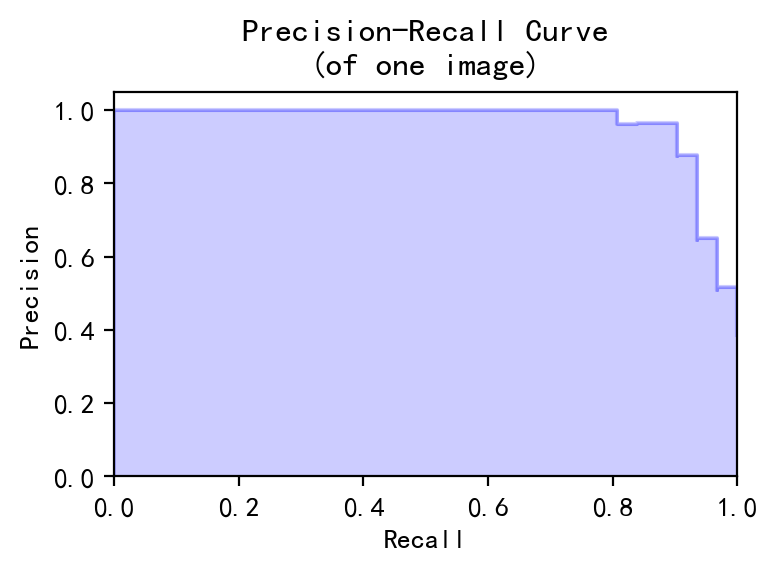

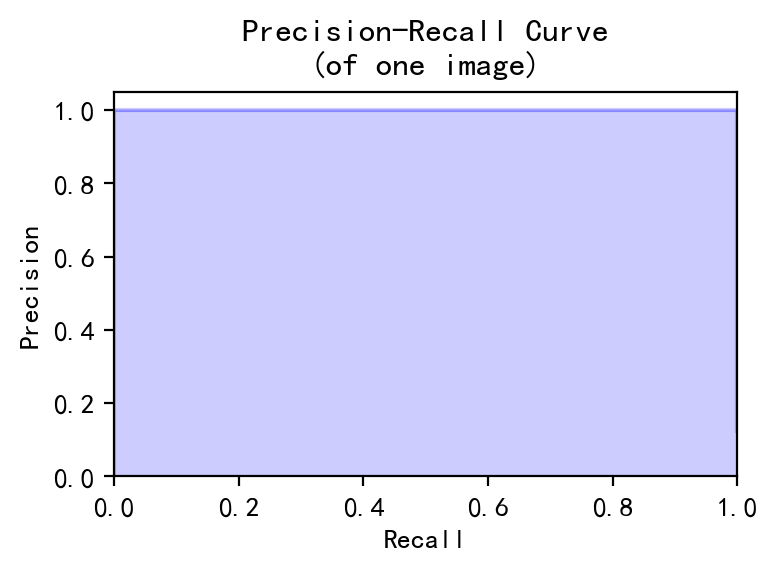

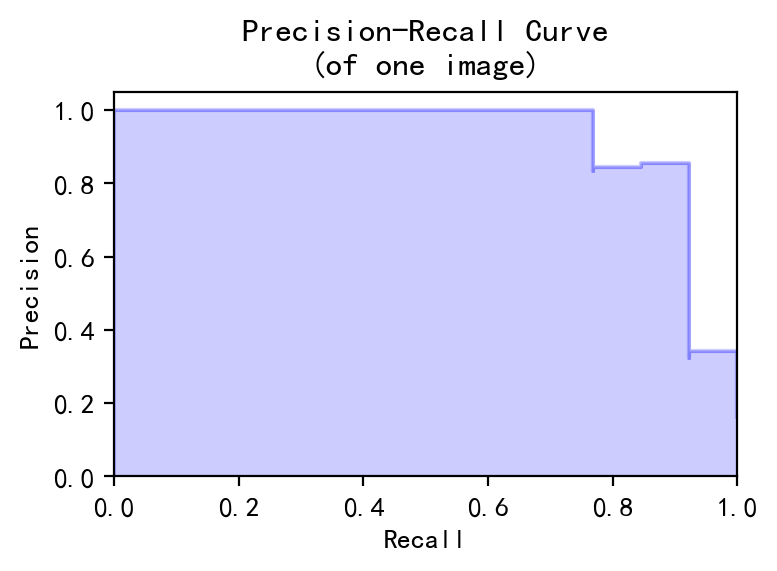

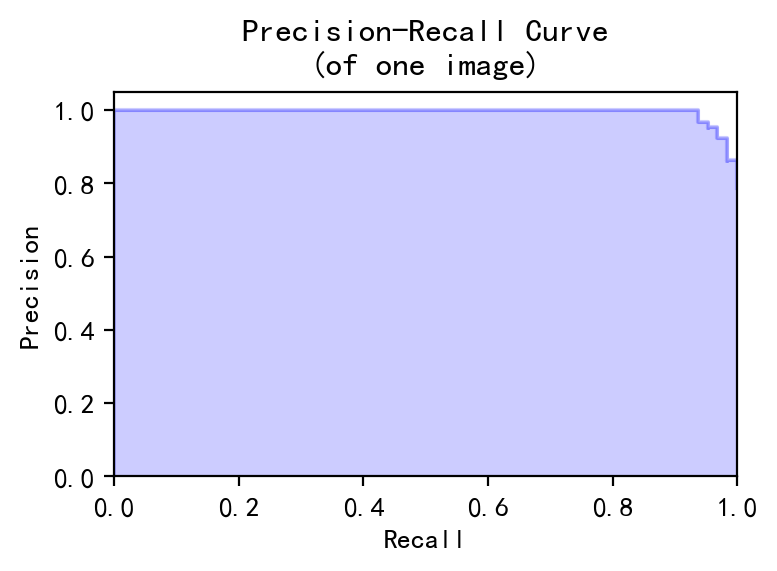

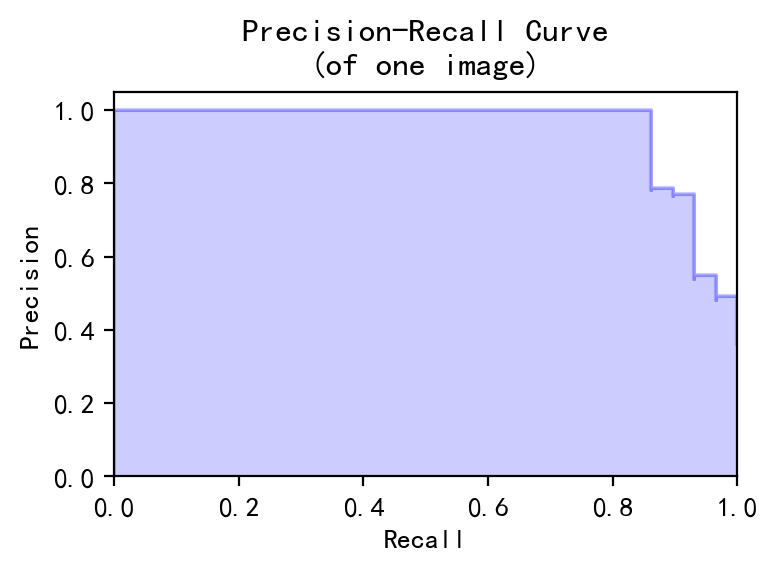

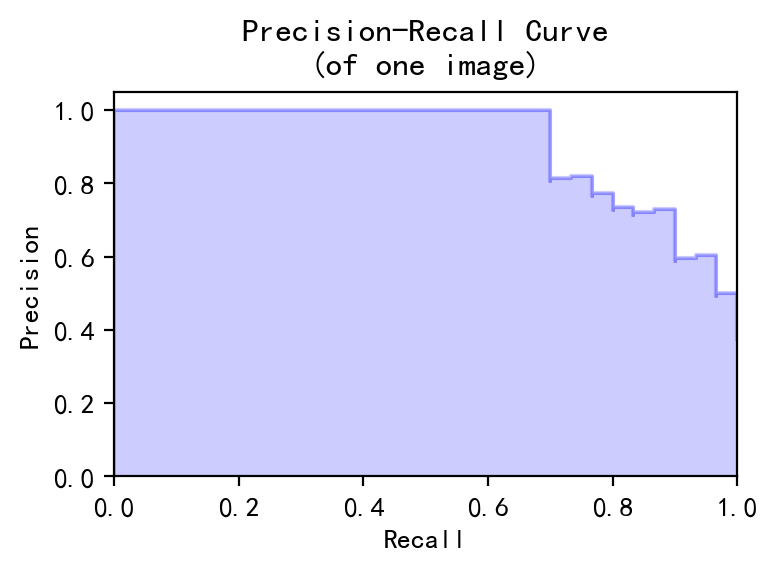

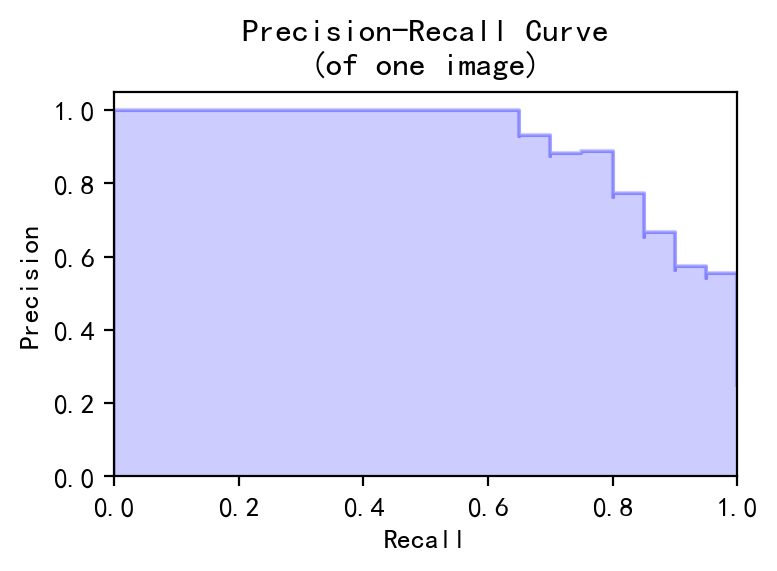

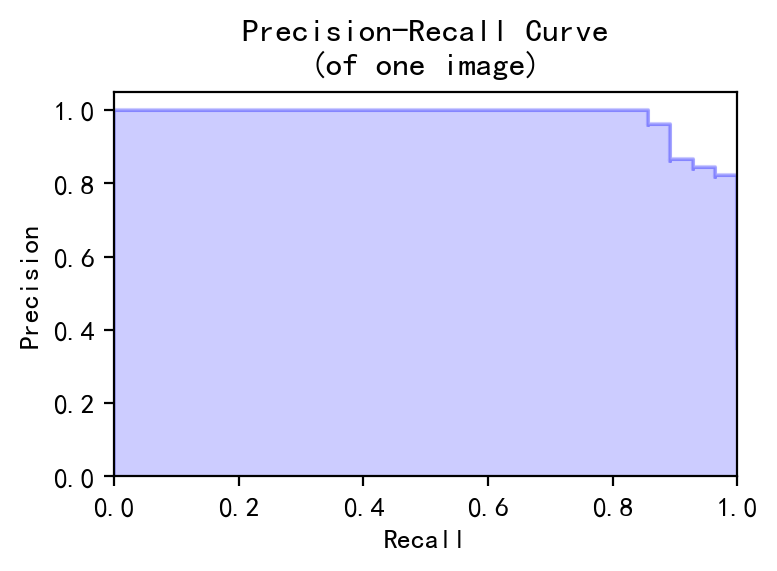

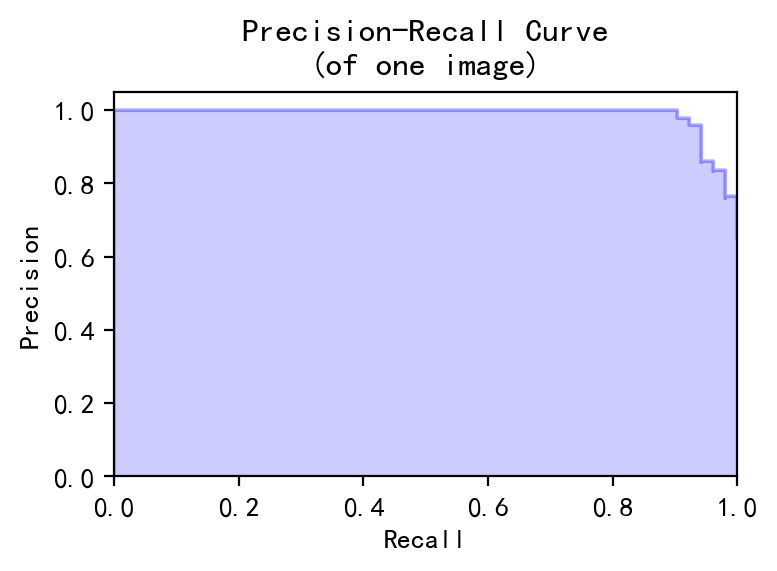

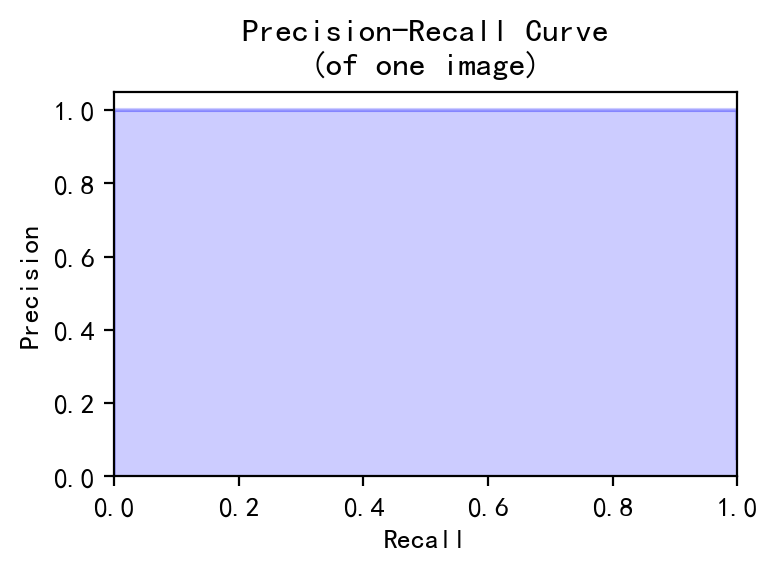

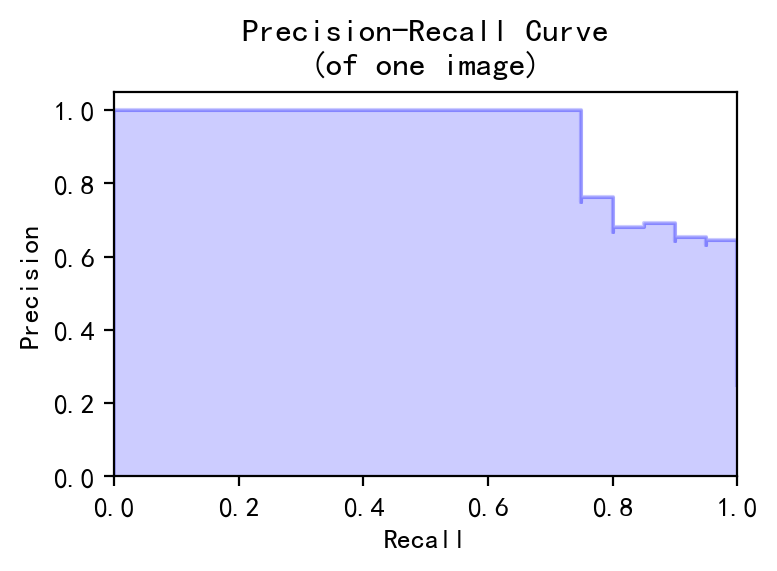

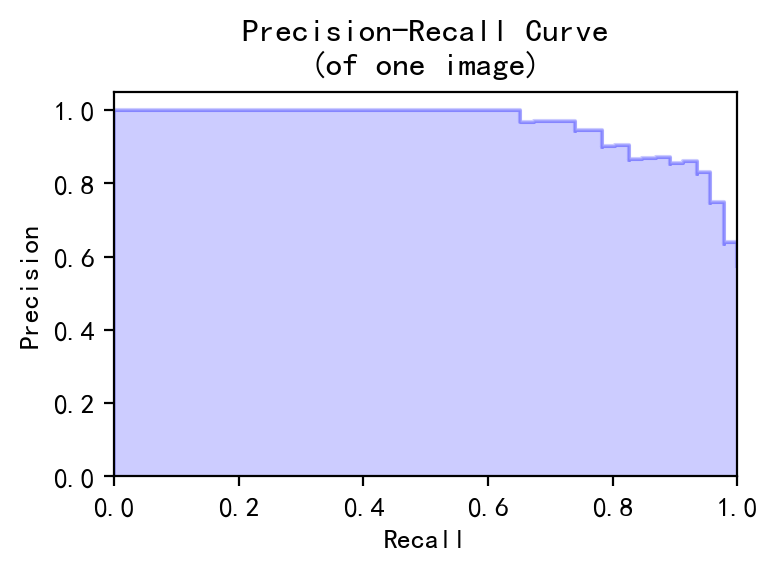

In [ ]:
step = 1
subtask_switch_step = 2
N_out = 10
uniform_randweight = np.ones(shape=(N_out,), dtype=np.float32) / N_out
def get_new_randweight():
    res = np.random.rand(N_out)
    summ = np.sum(res)
    if summ > 0:
        return res / summ
    else:
        return uniform_randweight
subtask_randweight = get_new_randweight()
def subtask_decay(step):
    return 0.93 ** step
    
for epoch_i in range(1, EPOCHS+1):
    batch_i = 1
    print('epoch %d/%d' % (epoch_i, EPOCHS))
    for x, y_main, y_type, y_t, y_b, y_r, y_u, _ in tqdm(train_loader, ascii=True):
        
        model.train()
        
        x = x.to(DEVICE)
        y_main = y_main.to(DEVICE)
        y_type = y_type.to(DEVICE)
        y_t = y_t.to(DEVICE)
        y_b = y_b.to(DEVICE)
        y_r = y_r.to(DEVICE)
        y_u = y_u.to(DEVICE)
        y_truth = pack_y(y_main, y_type, y_t, y_b, y_r, y_u)
        ct = (y_truth['c'] >= 0.5)

        optimizer.zero_grad()

        y = model(x)
        
        l_obj = loss_c_obj(y['c'][ct], y_truth['c'][ct]) * 20
        l_noobj = loss_c_noobj(y['c'][~ct], y_truth['c'][~ct]) * 10
        l_q = loss_q(y['q'][ct], y_truth['q'][ct]) * 20
        l_l = loss_l(y['l'][ct], y_truth['l'][ct]) / 2
        l_r = loss_r(y['r'][ct], y_truth['r'][ct]) / 2
        l_type = loss_type(y['type'].view(-1, y['type'].size(-1)), y_truth['type'].view(-1))
        l_dot_t = loss_dot_t(y['dot_t'].view(-1, y['dot_t'].size(-1)), y_truth['dot_t'].view(-1))
        l_dot_b = loss_dot_b(y['dot_b'].view(-1, y['dot_b'].size(-1)), y_truth['dot_b'].view(-1))
        l_dot_r = loss_dot_r(y['dot_r'].view(-1, y['dot_r'].size(-1)), y_truth['dot_r'].view(-1))
        l_uline = loss_uline(y['uline'].view(-1, y['uline'].size(-1)), y_truth['uline'].view(-1))
        
        decay = subtask_decay(step)
        weights = subtask_randweight * (decay) + uniform_randweight * (1 - decay)
        loss = 0
        for l, w in zip([l_q, l_l, l_r, l_obj, l_noobj, l_type, l_dot_t, l_dot_b, l_dot_r, l_uline], weights.tolist()):
            loss += l * w
        loss.backward()
        optimizer.step()

        if batch_i % 512 == 0:
            info = {
                'train_epoch_i': epoch_i,
                'train_batch_i': batch_i,
                'loss': loss.item(),
                'loss_q': l_q.item(),
                'loss_l': l_l.item(),
                'loss_r': l_r.item(),
                'loss_obj': l_obj.item(),
                'loss_noobj': l_noobj.item(),
                'loss_dot_t': l_dot_t.item(),
                'loss_dot_b': l_dot_b.item(),
                'loss_dot_r': l_dot_r.item(),
                'loss_uline': l_uline.item(),
                **eval_epoch(model, test_loader, preproc, 16, 1280),
            }
            if WANDB:
                wandb.log(info)
            step += 1
            
            NOW_SAVING_TO = os.path.join(CKPT_FOLDER, 'xsn(norm)_model_step=%04d.ckpt' % step)
            torch.save(model, NOW_SAVING_TO)
            # print("已保存模型至：", NOW_SAVING_TO)
            
            if step % 3 == 0:
                eval_list = eval_epoch_theta_y(model, test_loader, debug=False)
                plot_hist_info(eval_list, output_name=os.path.join(HIST_FOLDER, 'xsn(norm)_hist_step=%04d.png' % step))
    
        if batch_i % 50 == 0:
            subtask_randweight = get_new_randweight()

        batch_i += 1

In [ ]:
# NOW_SAVING_TO = os.path.join(CKPT_FOLDER, 'model_final.ckpt')
# torch.save(model, NOW_SAVING_TO)

In [ ]:
NOW_LOADING_FROM = os.path.join(CKPT_FOLDER, 'model_final_best.ckpt')
model = torch.load(NOW_LOADING_FROM)

In [ ]:
# # 测试评估函数的效果
# eval_epoch(model, test_loader, preproc, 16, 1280, debug=True)

# [C] 测试实际文献上的表现

In [122]:
PICS_ROOT = 'C:\\2_[OUT]-2023-09-24-20-26-30-FLATTENED'
PICS_INFO = [
    # {
    #     'file': 'V09_P0746.png',
    #     'y_min': 522,
    #     'y_max': 700,
    # },
    # {
    #     'file': 'V09_P0746.png',
    #     'y_min': 910,
    #     'y_max': 1082,
    # },
    # {
    #     'file': 'V09_P0746.png',
    #     'y_min': 2269,
    #     'y_max': 2471,
    # },
    # {
    #     'file': 'V12_P0397.png',
    #     'y_min': 431,
    #     'y_max': 593,
    # },
    # {
    #     'file': 'V12_P0441.png',
    #     'y_min': 765,
    #     'y_max': 886,
    # },
    # {
    #     'file': 'V04_P0453.png',
    #     'y_min': 1156,
    #     'y_max': 1328,
    # },
    # {
    #     'file': 'V16_P0475.png',
    #     'y_min': 1595,
    #     'y_max': 1733,
    # },
    # {
    #     'file': 'V16_P0670.png',
    #     'y_min': 2603,
    #     'y_max': 2724,
    # },
    # {
    #     'file': 'V16_P0774.png',
    #     'y_min': 2424,
    #     'y_max': 2562,
    # },
    # {
    #     'file': 'V16_P0816.png',
    #     'y_min': 772,
    #     'y_max': 893,
    # },
    # {
    #     'file': 'V16_P0810.png',
    #     'y_min': 1470,
    #     'y_max': 1584,
    # },
    # {
    #     'file': 'V12_P0267.png',
    #     'y_min': 2154,
    #     'y_max': 2269,
    # },
    # {
    #     'file': 'V12_P0267.png',
    #     'y_min': 2357,
    #     'y_max': 2478,
    # },
    # {
    #     'file': 'V15_P0654.png',
    #     'y_min': 438,
    #     'y_max': 569,
    # },
    # {
    #     'file': 'V15_P0654.png',
    #     'y_min': 818,
    #     'y_max': 949,
    # },
    # {
    #     'file': 'V15_P0654.png',
    #     'y_min': 1234,
    #     'y_max': 1380,
    # },
    # {
    #     'file': 'V10_P1022.png',
    #     'y_min': 830,
    #     'y_max': 1060,
    # },
    {
        'file': 'V10_P1041.png',
        'y_min': 681,
        'y_max': 807,
    },
]

In [123]:
def load_image_as_binary_target(path):
    '''
    从给入的路径 path 读入图像（应该为单通道图像）
    并通过阈值化得到 dtype 为 bool 的 ndarray 图像。
    '''
    
    pil_img = PIL.Image.open(path)
    img = np.array(pil_img)
    assert len(img.shape) == 2
    assert img.dtype == bool
    if img.max() <= 0:
        print("MyWarning: img.max() <= 0 in '%s'" % path, file=sys.stderr)
    return ~img

# temp_path = '.\\gen_pngs\\000001_000001.png'
# temp_result = load_image_as_binary(temp_path)
# print(temp_result.dtype)
# plt.imshow(temp_result, plt.cm.grey)

In [124]:
def preproc_transform_target(img, target_h, target_w, fill_value=0):
    
    img = img.copy().astype(np.float64)
    
    h0, w0 = img.shape
    aspect0 = w0 / h0
    if (aspect0 >= target_w / target_h):
        
        h1 = int(round(target_w / aspect0))
        img = skimage.transform.resize(img, (h1, target_w), mode='constant', cval=0.0)
        
        pad_v = (target_h - h1) / 2
        pad_u = int(round(pad_v if pad_v % 1 == 0 else pad_v - 0.5))
        pad_d = int(round(pad_v if pad_v % 1 == 0 else pad_v + 0.5))
        
        img_u = np.zeros(shape=(pad_u, target_w), dtype=np.float32)
        img_d = np.zeros(shape=(pad_d, target_w), dtype=np.float32)
        img = np.concatenate([img_u, img, img_d], axis=0)
        img = np.clip(img, 0.0, 1.0)
        
        return img
    
    else:
        
        w1 = int(round(target_h * aspect0))
        img = skimage.transform.resize(img, (target_h, w1), mode='constant', cval=0.0)
        
        pad_h = (target_w - w1) / 2
        pad_l = int(round(pad_h if pad_h % 1 == 0 else pad_h - 0.5))
        pad_r = int(round(pad_h if pad_h % 1 == 0 else pad_h + 0.5))
        
        img_l = np.zeros(shape=(target_h, pad_l), dtype=np.float32)
        img_r = np.zeros(shape=(target_h, pad_r), dtype=np.float32)
        img = np.concatenate([img_l, img, img_r], axis=1)
        img = np.clip(img, 0.0, 1.0)
        
        return img

In [125]:
import music21 as m21

In [126]:
MAP_TYPES = ['rest', 'C', 'D', 'E', 'F', 'G', 'A', 'B', 'bar']

def get_pitch(type, dot_t, dot_b):
    assert len(type) == 1
    return type + str(4 + dot_t - dot_b)

def get_duration(uline, dot_r):
    return (0.5) ** uline * ((1.0 + 0.5 ** dot_r) if dot_r > 1 else 1.0)


def draw_xsnote_debug(yy, img, W_b, color_x=(0, 0, 255), color_l=(0, 255, 255), color_r=(255, 0, 255), output_path=None, half_resized=False):
    
    img = img.copy()
    if img.dtype == bool:
        img = img.astype(np.uint8) * 255
    elif img.dtype == np.float32 or img.dtype == np.float64:
        img = np.clip(np.round(img * 255), 0, 255).astype(np.uint8)
    if len(img.shape) == 2:
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    
    for key in yy.keys():
        yy[key] = yy[key].detach().detach().cpu().numpy()

    stream = m21.stream.Stream()
    ts = m21.meter.TimeSignature('4/4')
    stream.append(ts)

    last_object = None

    h, w, _ = img.shape
    for p in range(yy['c'].shape[1]):
        if yy['c'][0, p] >= 0.5:

            x0 = pq_to_x(p, yy['q'][0, p], W_b)
            x = clamp_x(int(round(x0)), w)
            rr, cc = skimage.draw.line(0, x, h-1, x)
            img[rr, cc, :] = np.array(color_x).reshape((1, 3))
            x_min = clamp_x(int(round(x0 - yy['l'][0, p])), w)
            rr, cc = skimage.draw.line(0, x_min, h-1, x_min)
            img[rr, cc, :] = np.array(color_l).reshape((1, 3))
            x_max = clamp_x(int(round(x0 + yy['r'][0, p])), w)
            rr, cc = skimage.draw.line(0, x_max, h-1, x_max)
            img[rr, cc, :] = np.array(color_r).reshape((1, 3))

            type = MAP_TYPES[np.argmax(yy['type'][0, p])]
            dot_t = np.argmax(yy['dot_t'][0, p])
            dot_b = np.argmax(yy['dot_b'][0, p])
            dot_r = np.argmax(yy['dot_r'][0, p])
            uline = np.argmax(yy['uline'][0, p])

            if type == 'bar':
                last_object.quarterLength += 1

            elif type == 'rest':
                duration = get_duration(uline, dot_r)
                if last_object is not None:
                    stream.append(last_object)
                last_object = m21.note.Rest(duration=m21.duration.Duration(duration))

            else:
                pitch = get_pitch(type, dot_t, dot_b)
                duration = get_duration(uline, dot_r)
                if last_object is not None:
                    stream.append(last_object)
                last_object = m21.note.Note(pitch, duration=m21.duration.Duration(duration))
            
    if last_object is not None:
        stream.append(last_object)

    stream.write('musicxml.png', "%s.music.png" % output_path)
            
    if output_path is not None:
        PIL.Image.fromarray(img).save(output_path, 'PNG')
    return img

In [127]:
TARGET_H = 128
TARGET_W = 1280

model.eval()
with torch.no_grad():
    for i, pic_info in enumerate(PICS_INFO):
        path = os.path.join(PICS_ROOT, pic_info['file'])
        img = load_image_as_binary_target(path)
        img = img[pic_info['y_min']:pic_info['y_max']]
        img = preproc_transform_target(img, TARGET_H, TARGET_W)
        PIL.Image.fromarray(np.clip(np.round(img * 255), 0, 255).astype(np.uint8)).save('xsn_test_%d_before.png' % (i+1), 'PNG')

        x = torch.from_numpy(img.astype(np.float32)).unsqueeze(0)
        x = x.to(DEVICE)
        y = model(x)
        yy = inv_preproc(y, preproc)
        print(yy.keys())
        
        print("id=%d" % (i+1))
        draw_xsnote_debug(yy, img, 16, output_path='xsn_test_%d_after.png' % (i+1))

dict_keys(['c', 'type', 'dot_t', 'dot_b', 'dot_r', 'uline', 'q', 'l', 'r'])
id=1


In [ ]:
# import numpy as np
# from sklearn.metrics import average_precision_score

# def compute_iou(box1, box2):
#     l1, r1, u1, b1, _ = box1
#     l2, r2, u2, b2, _ = box2

#     overlap_l = max(l1, l2)
#     overlap_r = min(r1, r2)
#     overlap_u = max(u1, u2)
#     overlap_b = min(b1, b2)

#     overlap_area = max(0, overlap_r - overlap_l) * max(0, overlap_b - overlap_u)
#     area1 = max(0, r1 - l1) * max(0, b1 - u1)
#     area2 = max(0, r2 - l2) * max(0, b2 - u2)
    
#     union_area = area1 + area2 - overlap_area
#     assert union_area > 0

#     iou = overlap_area / union_area
#     return iou

# def compute_AP(P, G, iou_threshold=0.5):
    
#     ious = np.zeros((len(P), len(G)))
#     for i in range(len(P)):
#         for j in range(len(G)):
#             ious[i,j] = compute_iou(P[i], G[j])
#     ious = (ious >= iou_threshold).astype(int)  # IoU threshold
#     prediction_counts = np.sum(ious, axis=1)
#     prediction_correctness = (prediction_counts > 0).astype(int)
    
#     prediction_confidence = P[:, -1]
#     return average_precision_score(prediction_correctness, prediction_confidence)